In [25]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Activation
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Activation
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import RandomSearch

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
Ravdess = "C:/Users/Алексей/Desktop/учёба/python/speech-emotion-recognition-ravdess-data"
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + '/' + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
1,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
2,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
3,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
4,calm,C:/Users/Алексей/Desktop/учёба/python/speech-e...


In [3]:
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
1,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
2,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
3,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
4,calm,C:/Users/Алексей/Desktop/учёба/python/speech-e...


In [4]:
data_path.Path[0]

'C:/Users/Алексей/Desktop/учёба/python/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-01-01.wav'

In [5]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [6]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [7]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [8]:
len(X), len(Y), data_path.Path.shape


(4320, 4320, (1440,))

In [9]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237707,0.659504,0.688300,0.660306,0.668153,0.691578,0.679806,0.700728,0.743931,0.777429,...,1.971535e-16,1.694119e-16,1.561859e-16,1.566727e-16,1.521193e-16,1.325442e-16,1.309995e-16,1.341276e-16,1.188672e-16,neutral
1,0.287082,0.738863,0.804378,0.784031,0.771132,0.782902,0.713630,0.664289,0.701853,0.734604,...,6.538188e-06,6.869678e-06,6.794337e-06,6.618857e-06,6.846190e-06,6.992678e-06,6.977130e-06,6.617423e-06,6.854886e-06,neutral
2,0.166967,0.578606,0.608995,0.669059,0.597341,0.606837,0.673561,0.681284,0.704720,0.715759,...,8.504842e-13,7.684326e-13,5.920987e-13,5.803375e-13,6.579538e-13,5.743235e-13,4.853721e-13,5.919732e-13,5.719862e-13,neutral
3,0.207284,0.649996,0.689978,0.661347,0.645627,0.683498,0.684929,0.679601,0.732510,0.756296,...,9.362395e-17,1.017879e-16,8.988049e-17,9.321180e-17,9.068552e-17,9.977286e-17,8.490875e-17,8.585167e-17,9.594946e-17,neutral
4,0.319960,0.778590,0.830067,0.808287,0.781303,0.795099,0.740387,0.658335,0.700350,0.738046,...,9.125810e-05,9.226552e-05,9.394767e-05,9.693041e-05,9.349613e-05,8.454741e-05,8.728756e-05,9.245701e-05,9.424148e-05,neutral


In [10]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
Y.shape

(4320,)

In [11]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [12]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [13]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [14]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [15]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [33]:
def build_model2(hp): 
    model=Sequential()
    model.add(Conv1D(hp.Int('input_units_1',
                                min_value=32,
                                max_value=512,
                                step=32), kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(hp.Int('input_units_2',
                                min_value=32,
                                max_value=512,
                                step=32), kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(hp.Int('input_units_3',
                                min_value=32,
                                max_value=512,
                                step=32), kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    
    return model
    #model.summary()

In [34]:
import time
LOG_DIR = f"{int(time.time())}"
tuner = RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=20,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)

tuner.search(x=x_train,
             y=y_train,
             verbose=2, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=2,
             batch_size=64,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(x_test, y_test))

Trial 20 Complete [00h 00m 13s]
val_accuracy: 0.2611111104488373

Best val_accuracy So Far: 0.3296296298503876
Total elapsed time: 00h 10m 00s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [35]:
tuner.get_best_hyperparameters()[0].values


{'input_units_1': 128, 'input_units_2': 32, 'input_units_3': 320}

In [18]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=1, validation_data=(x_test, y_test), callbacks=[rlrp])

51/51 [==============================] - 21s 407ms/step - loss: 1.7960 - accuracy: 0.2867 - val_loss: 1.6795 - val_accuracy: 0.3639


34/34 [==============================] - 3s 76ms/step - loss: 1.6795 - accuracy: 0.3639
Accuracy of our model on test data :  36.38888895511627 %


ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

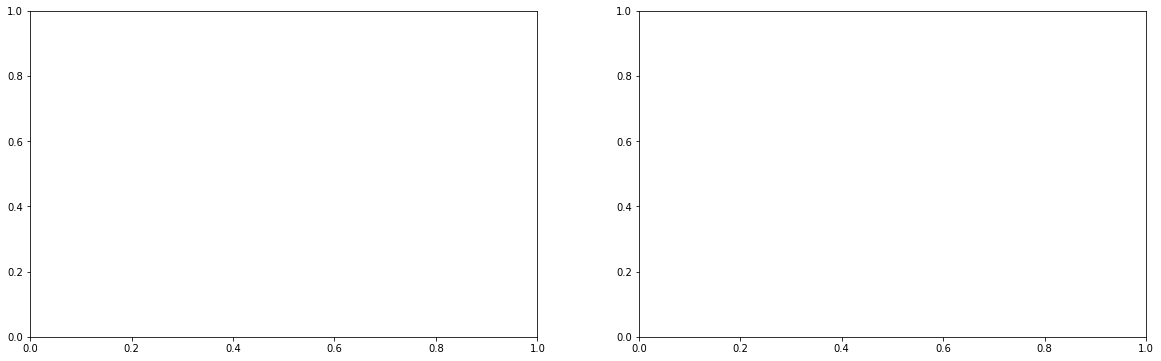

In [19]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))


In [ ]:
model.save('models/keras.h5')

In [ ]:
new_model = tf.keras.models.load_model('models/keras.h5')

In [ ]:
pred_test = new_model.predict(x_test)
pred_test
y_pred = encoder.inverse_transform(pred_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [29]:
y_pred

NameError: name 'y_pred' is not defined